# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

# Setup

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['18']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}',
        'out_path_plots': f'Plots/Subject{sub}'
    }

In [3]:
raw_file = h5py.File(file_paths['18']['raw_path'])
setup_data = mat73.loadmat(file_paths['18']['setup_path'])

out_path_plots = file_paths['18']['out_path_plots']
out_path_metrics = file_paths['18']['out_path_metrics']

In [4]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [6]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [30]:
# Trying to predict card value from neural data

card_categories = []
idxs_to_keep = []

for i, card in enumerate(subject_cards):
    if card < 6:
        card_categories.append(0)
        idxs_to_keep.append(i)
    elif card > 6:
        card_categories.append(1)
        idxs_to_keep.append(i)

card_categories = np.asarray(card_categories)

data = np.load(file_paths['18']['data_path'])[idxs_to_keep,:,:,40:100] # 40:100 is the time window of interest for visual cue as event

In [16]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [18]:
data = np.load(file_paths['18']['data_path'])[:,:,:,:60] # 0:60 is the time window of interest for movement onset as event
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Matplotlib Settings

In [17]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 22

## Create Frequency Bands

In [18]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [19]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Model Training

In [31]:
from logistic_regression import TrainOptimalTimeWindows

clf = TrainOptimalTimeWindows(data=f_band_data, setup_data=setup_data)

In [32]:
filtered_num_channels = clf.filter_channels()[2]

In [33]:
clf.train_on_optimal_time_windows(f_band_data, card_categories, n_processes=20, n_channels=filtered_num_channels)

Channel 165 done
Channel 173 done
Channel 105 done
Channel 92 done
Channel 172 done
Channel 162 done
Channel 33 done
Channel 178 done
Channel 14 done
Channel 52 done
Channel 166 done
Channel 47 done
Channel 84 done
Channel 56 done
Channel 114 done
Channel 72 done
Channel 83 done
Channel 133 done
Channel 54 done
Channel 60 done
Channel 3 done
Channel 127 done
Channel 148 done
Channel 1 done
Channel 100 done
Channel 179 done
Channel 66 done
Channel 21 done
Channel 57 done
Channel 70 done
Channel 164 done
Channel 108 done
Channel 23 done
Channel 147 done
Channel 146 done
Channel 63 done
Channel 94 done
Channel 171 done
Channel 142 done
Channel 0 done
Channel 167 done
Channel 159 done
Channel 153 done
Channel 58 done
Channel 62 done
Channel 69 done
Channel 143 done
Channel 163 done
Channel 170 done
Channel 67 done
Channel 130 done
Channel 71 done
Channel 79 done
Channel 68 done
Channel 134 done
Channel 82 done
Channel 78 done
Channel 46 done
Channel 174 done
Channel 124 done
Channel 125 do

In [34]:
clf._optimal_time_windows_per_channel

[[146, [8, 34], 0.7350000000000001],
 [13, [33, 35], 0.7103333333333335],
 [79, [11, 11], 0.6953333333333334],
 [142, [26, 32], 0.6863333333333335],
 [61, [4, 42], 0.6863333333333334],
 [106, [38, 44], 0.6863333333333334],
 [169, [26, 32], 0.6863333333333334],
 [47, [10, 20], 0.686],
 [70, [40, 46], 0.686],
 [46, [29, 29], 0.6856666666666666],
 [102, [57, 57], 0.6796666666666666],
 [101, [42, 50], 0.6783333333333333],
 [159, [44, 54], 0.6783333333333333],
 [166, [7, 7], 0.6783333333333333],
 [162, [50, 50], 0.678],
 [53, [25, 25], 0.671],
 [2, [50, 54], 0.6706666666666667],
 [60, [8, 36], 0.6703333333333334],
 [111, [21, 23], 0.6699999999999999],
 [78, [10, 12], 0.6693333333333334],
 [154, [49, 53], 0.6693333333333334],
 [156, [7, 15], 0.669],
 [15, [48, 48], 0.6689999999999999],
 [99, [18, 18], 0.6686666666666666],
 [123, [56, 60], 0.6686666666666666],
 [0, [57, 59], 0.6623333333333333],
 [33, [28, 34], 0.6623333333333333],
 [108, [14, 48], 0.6616666666666667],
 [14, [53, 57], 0.66133

In [36]:
optimal_channels = clf.get_optimal_channel_combination(card_categories, max_channels=10)[0]

In [37]:
optimal_channels

[[146, 13, 79, 142, 61, 46], 0.8842975206611571]

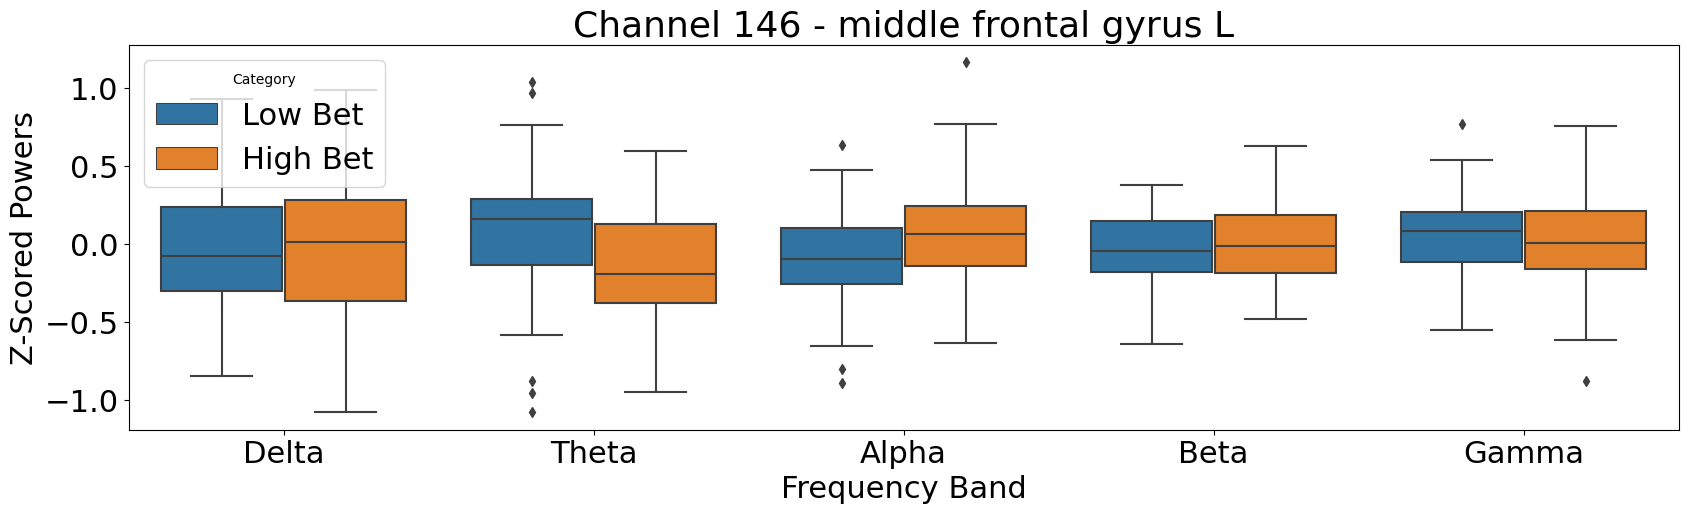

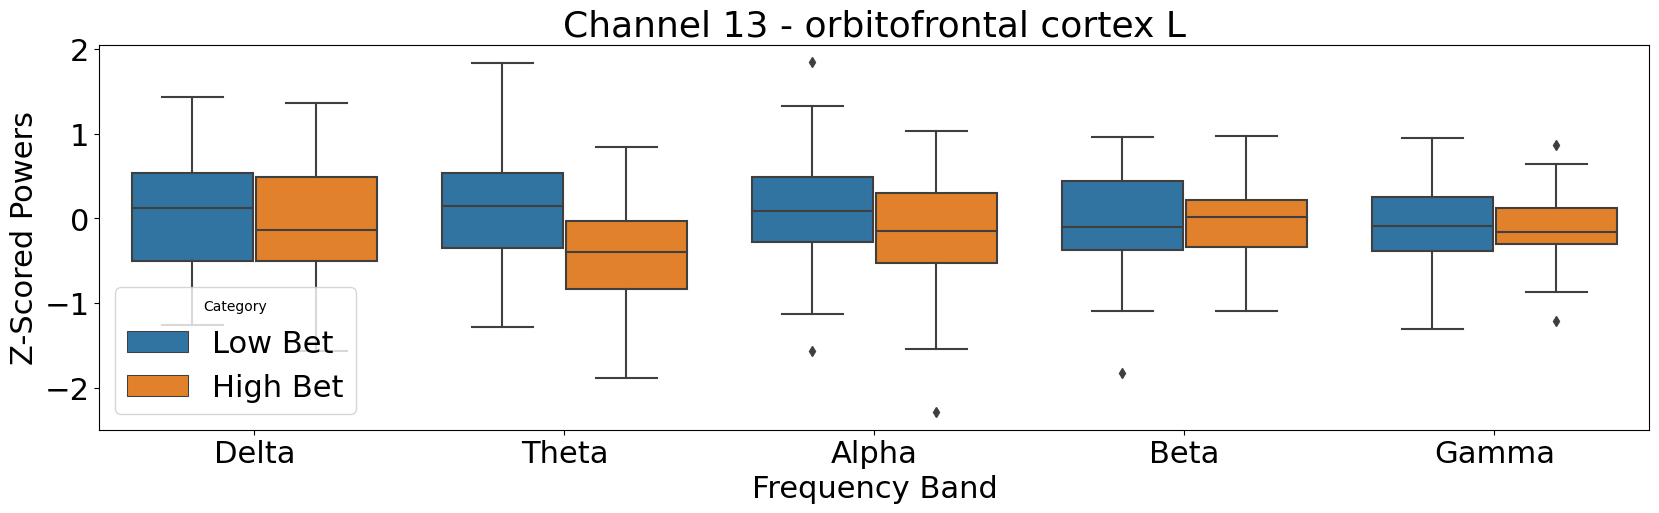

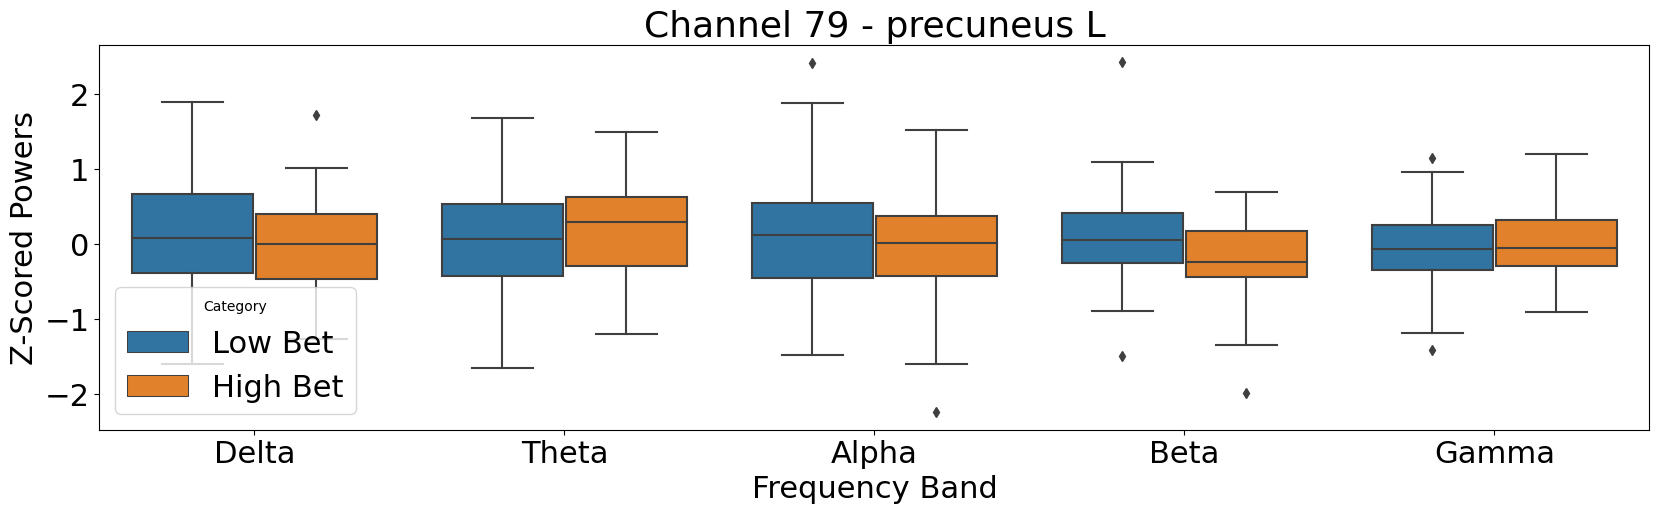

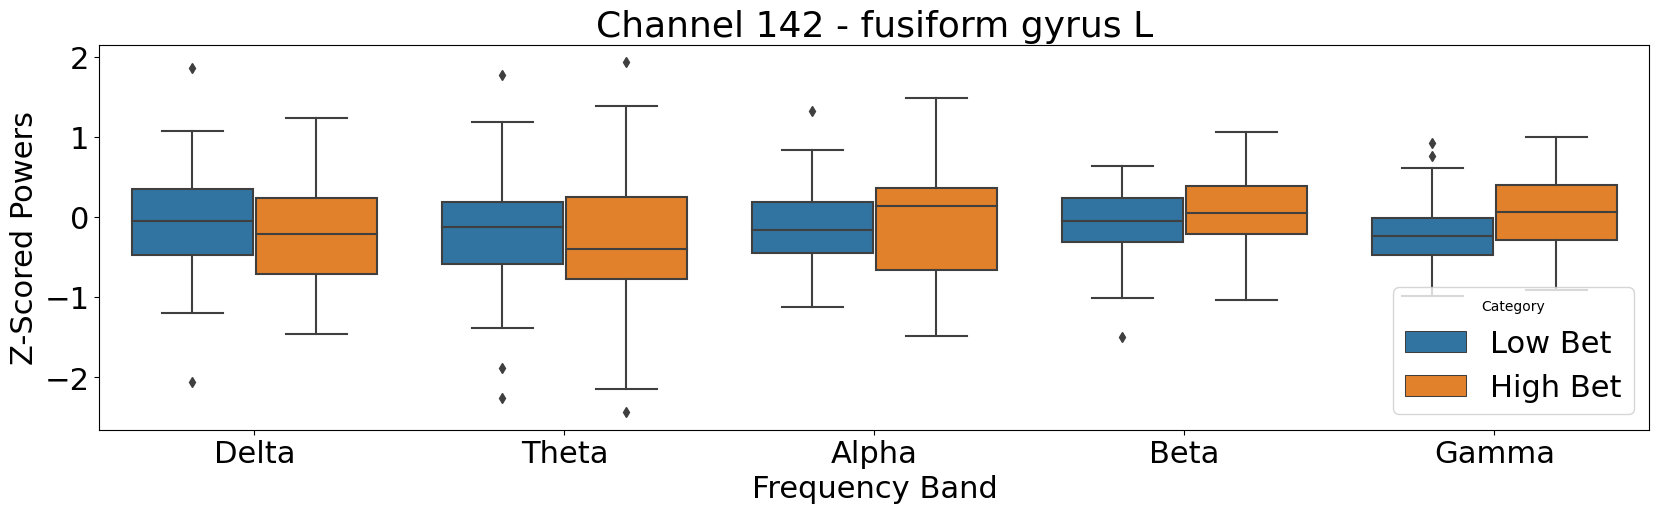

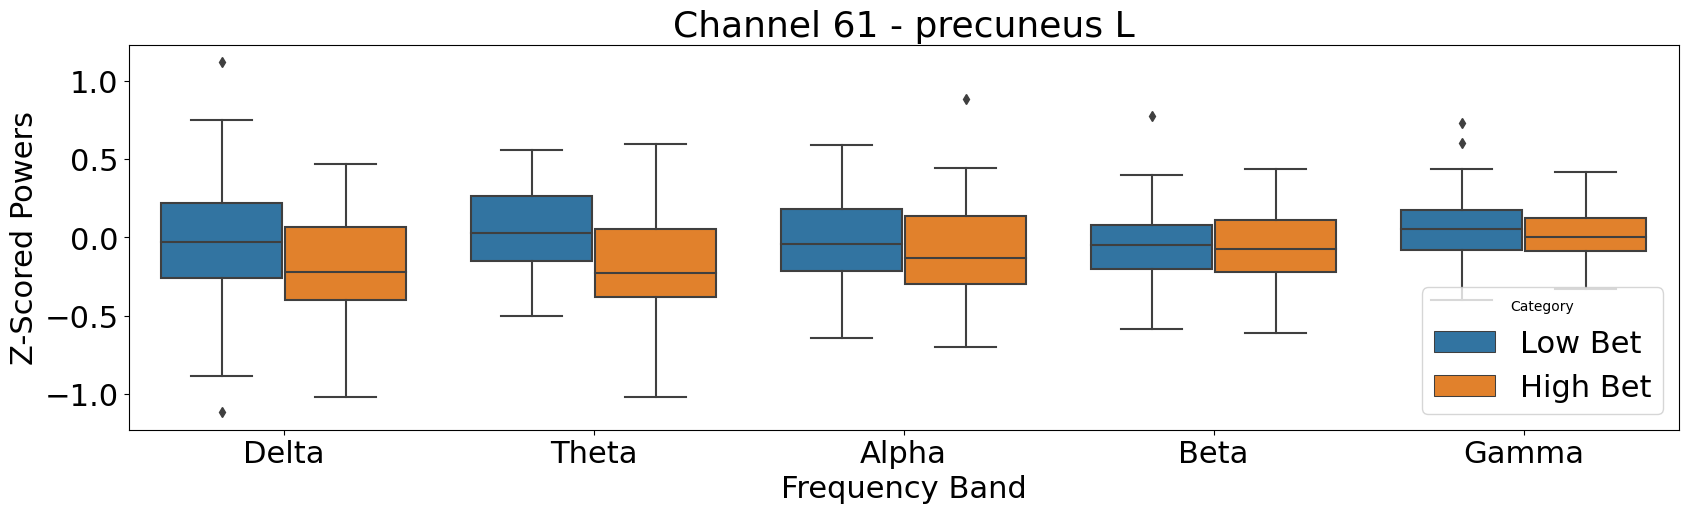

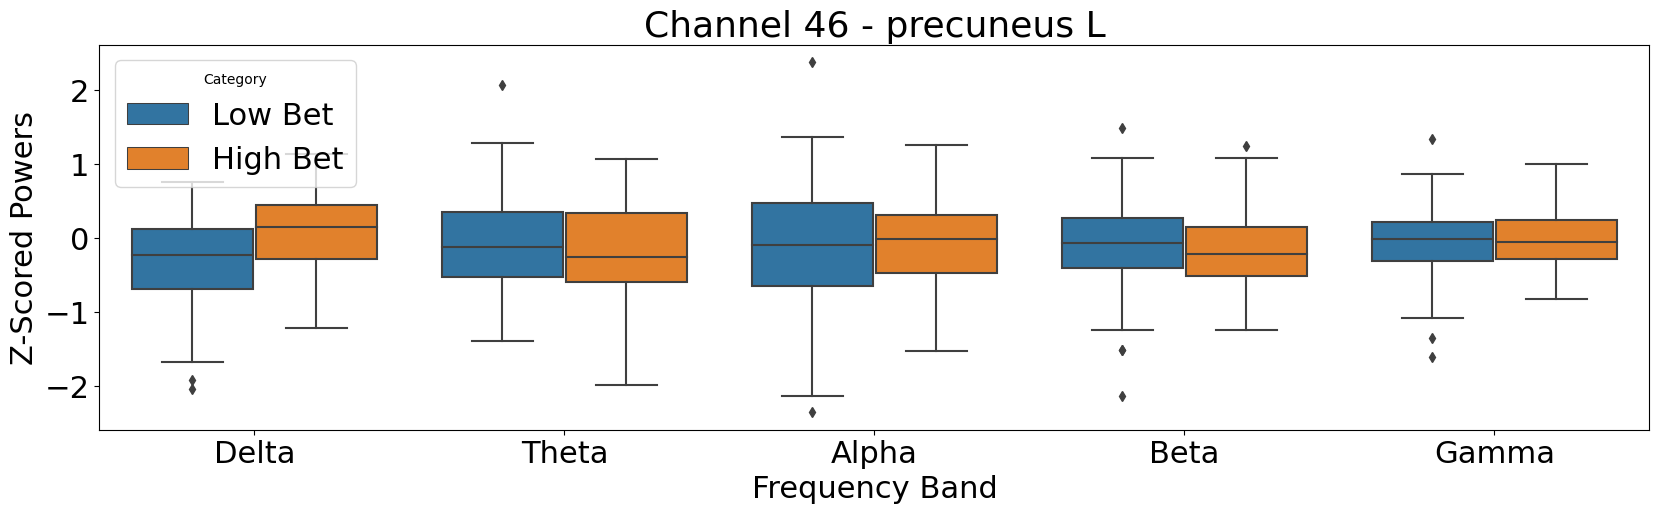

In [39]:
clf.plot_freq_box_plots(card_categories, optimal_channels[0], out_path_plots)

[61, 146, 79, 142, 46, 13]


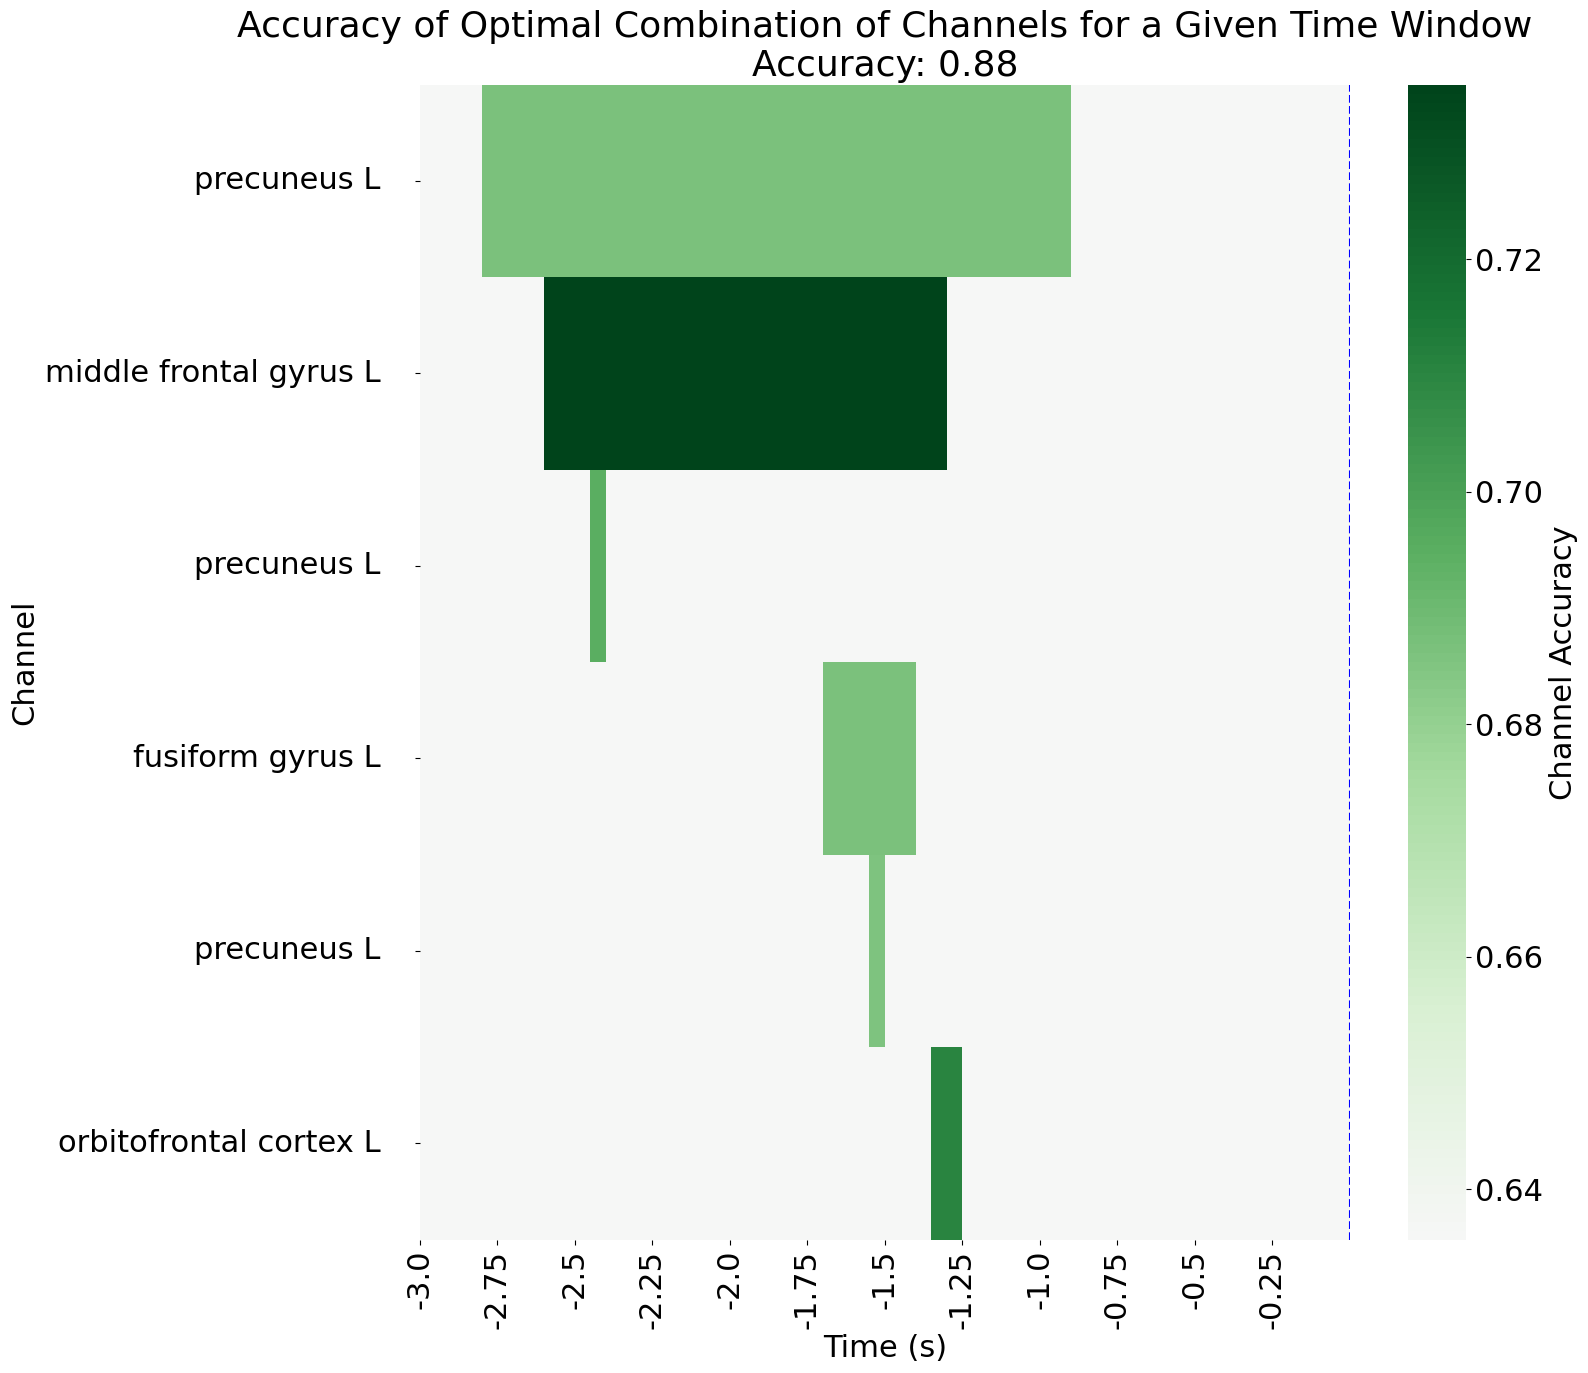

In [40]:
clf.plot_heatmap(optimal_channels[0], 3, optimal_channels[1], True, out_path_plots)

# Analysis

In [8]:
def find_shared_brain_areas(brain_area_combinations):
    flatten_list = lambda l: [item for sublist in l for item in sublist]
    unique_brain_areas = np.unique(flatten_list(brain_area_combinations))

    shared_brain_areas = []
    for brain_area in unique_brain_areas:
        i = 0
        for combination in brain_area_combinations:
            if brain_area in combination:
                i += 1
        if i > 1:
            shared_brain_areas.append([brain_area, i])

    shared_brain_areas.sort(key=lambda x: x[1], reverse=True)
    
    return shared_brain_areas

### Find which brain regions that contribute to decision-making are shared among subjects (movement onset, -3s to 0s) [logistic regression]

In [17]:
channel_combinations_for_movement = []
optimal_channel_combinations_for_movement = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_logistic_movement_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_logistic_movement_optimal_time_window_optimal_channel_combination_10.npy'))

In [18]:
find_shared_brain_areas(optimal_channel_combinations_for_movement)

[['middle temporal gyrus L', 4],
 ['angular gyrus R', 3],
 ['cuneus R', 2],
 ['fusiform gyrus L', 2],
 ['hippocampus (anterior) L', 2],
 ['insular cortex (anterior) R', 2],
 ['middle temporal gyrus R', 2],
 ['occipital gyrus R', 2],
 ['parietal operculum L', 2],
 ['supramarginal gyrus L', 2],
 ['supramarginal gyrus R', 2]]

In [36]:
find_shared_brain_areas(optimal_channel_combinations_for_movement)

[['hippocampus (anterior) L', 3],
 ['middle temporal gyrus L', 3],
 ['cingulate cortex (posterior) R', 2],
 ['cuneus R', 2],
 ['fusiform gyrus L', 2],
 ['inferior frontal gyrus (pars triangularis) R', 2],
 ['insular cortex (anterior) R', 2],
 ['intraparietal sulcus R', 2],
 ['middle temporal gyrus R', 2],
 ['occipital gyrus L', 2],
 ['occipital gyrus R', 2],
 ['parietooccipital sulcus L', 2],
 ['supramarginal gyrus L', 2],
 ['supramarginal gyrus R', 2]]

### Random State: 42

In [37]:
channel_combinations_for_movement = []
optimal_channel_combinations_for_movement = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_logistic_42_movement_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_logistic_42_movement_optimal_time_window_optimal_channel_combination.npy'))

In [38]:
find_shared_brain_areas(optimal_channel_combinations_for_movement)

[['hippocampus (anterior) L', 3],
 ['middle temporal gyrus L', 3],
 ['cingulate cortex (posterior) R', 2],
 ['cuneus R', 2],
 ['fusiform gyrus L', 2],
 ['inferior frontal gyrus (pars triangularis) R', 2],
 ['insular cortex (anterior) R', 2],
 ['intraparietal sulcus R', 2],
 ['middle temporal gyrus R', 2],
 ['occipital gyrus L', 2],
 ['occipital gyrus R', 2],
 ['supramarginal gyrus L', 2],
 ['supramarginal gyrus R', 2]]

### Find which brain regions that contribute to decision-making are shared among subjects (movement onset, -3s to 0s) [LDA]

In [13]:
channel_combinations_for_movement = []
optimal_channel_combinations_for_movement = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_lda_movement_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_lda_movement_optimal_time_window_optimal_channel_combination.npy'))

In [14]:
find_shared_brain_areas(optimal_channel_combinations_for_movement)

[['cingulate cortex (posterior) R', 3],
 ['middle temporal gyrus L', 3],
 ['middle temporal gyrus R', 3],
 ['supramarginal gyrus L', 3],
 ['cuneus R', 2],
 ['fusiform gyrus L', 2],
 ['insular cortex (anterior) R', 2],
 ['occipital gyrus L', 2],
 ['parietal operculum L', 2],
 ['superior temporal sulcus R', 2],
 ['supramarginal gyrus R', 2]]

In [15]:
channel_combinations_for_movement = []
optimal_channel_combinations_for_movement = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_lda_movement_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations_for_movement.append(np.load(f'Metrics/Subject{sub}_lda_movement_optimal_time_window_optimal_channel_combination_10.npy'))

In [16]:
find_shared_brain_areas(optimal_channel_combinations_for_movement)

[['fusiform gyrus L', 3],
 ['cingulate cortex (posterior) R', 2],
 ['hippocampus (anterior) L', 2],
 ['insular cortex (anterior) R', 2],
 ['middle temporal gyrus L', 2],
 ['middle temporal gyrus R', 2],
 ['occipital gyrus L', 2],
 ['superior temporal sulcus R', 2],
 ['supramarginal gyrus L', 2],
 ['supramarginal gyrus R', 2]]

### Find which brain regions that contribute to decision-making are shared among subjects (visual cue)

In [44]:
channel_combinations_for_vis_stim = []
optimal_channel_combinations_for_vis_stim = []

subs = ['06','07','10','12','13','15','16','17','18','21']

for sub in subs:
    channel_combinations_for_vis_stim.append(np.load(f'Metrics/Subject{sub}_vis_stim_optimal_time_window_channel_combination.npy'))
    optimal_channel_combinations_for_vis_stim.append(np.load(f'Metrics/Subject{sub}_vis_stim_optimal_time_window_optimal_channel_combination.npy'))

In [45]:
find_shared_brain_areas(optimal_channel_combinations_for_vis_stim)

[['cingulate cortex (posterior) R', 3],
 ['fusiform gyrus L', 3],
 ['middle temporal gyrus R', 3],
 ['superior temporal gyrus (planum temporale) L', 3],
 ['angular gyrus R', 2],
 ['cuneus R', 2],
 ['fusiform gyrus R', 2],
 ['hippocampus (posterior) L', 2],
 ['insular cortex (posterior) R', 2],
 ['intraparietal sulcus R', 2],
 ['middle temporal gyrus L', 2],
 ['occipital gyrus (lateral) L', 2],
 ['occipital gyrus L', 2],
 ['parietal operculum L', 2],
 ['parietooccipital sulcus L', 2],
 ['superior temporal gyrus (planum temporale) R', 2],
 ['supramarginal gyrus L', 2],
 ['temporal pole R', 2]]

In [46]:
find_shared_brain_areas(channel_combinations_for_vis_stim)

[['cingulate cortex (posterior) R', 4],
 ['middle temporal gyrus R', 4],
 ['fusiform gyrus L', 3],
 ['parietal operculum L', 3],
 ['precuneus R', 3],
 ['superior temporal gyrus (planum temporale) R', 3],
 ['supramarginal gyrus L', 3],
 ['angular gyrus R', 2],
 ['cuneus R', 2],
 ['entorhinal cortex L', 2],
 ['fusiform gyrus R', 2],
 ['hippocampus (anterior) L', 2],
 ['hippocampus (anterior) R', 2],
 ['hippocampus (posterior) R', 2],
 ['inferior temporal sulcus R', 2],
 ['insular cortex (posterior) R', 2],
 ['intraparietal sulcus R', 2],
 ['lingula gyrus R', 2],
 ['middle temporal gyrus L', 2],
 ['occipital gyrus L', 2],
 ['occipital gyrus R', 2],
 ['superior temporal gyrus (planum temporale) L', 2],
 ['superior temporal sulcus R', 2],
 ['temporal pole R', 2]]

## Extraneous Code